# Semantic Segmentation

## Introduction
This project aims to implement semantic segmentation using deep learning techniques within the realm of computer vision. Semantic segmentation involves classifying each pixel in an image into predefined categories, providing a detailed understanding of the scene. In the broader context of computer vision, this project contributes to the advancement of image analysis, enabling applications such as autonomous vehicles, medical imaging, and augmented reality

## Dataset description
### City Scapes Image Segmentation

### About Dataset

#### Context

Cityscapes data (dataset home page) contains labeled videos taken from vehicles driven in Germany. This version is a processed subsample created as part of the Pix2Pix paper. The dataset has still images from the original videos, and the semantic segmentation labels are shown in images alongside the original image. This is one of the best datasets around for semantic segmentation tasks. The dataset consists of 297

#### Content

This dataset has 2975 training images files and 500 validation image files. Each image file is 256x512 pixels, and each file is a composite with the original photo on the left half of the image, alongside the labeled image (output of semantic segmentation) on the right half.

Example image from the dataset is shown below:

![1.jpg](./1.jpg)

## Importing libraries

In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Layer, Conv2D, Conv2DTranspose, MaxPooling2D, Dropout, concatenate, Activation,UpSampling2D
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras import backend as K

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import os
import cv2 as cv

from tqdm import tqdm
from PIL import Image

import os
import warnings

from collections import namedtuple

# pytorch dependency
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import Tensor

# creatation and transformations for the dataset
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

from collections import defaultdict

from IPython.display import clear_output

from time import time

from typing import Tuple
from collections import namedtuple

from skimage import color, io, img_as_ubyte,  feature
from skimage.feature import graycomatrix, graycoprops
from skimage.measure import shannon_entropy
from scipy.stats import describe

from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

sns.set_style('darkgrid')
warnings.filterwarnings('ignore')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 2.1 Data set validation

### Get filepaths

In [7]:
#datapath = 'C:/Users/belal/OneDrive/Desktop/Belal College/Term 5/Deep learning/Work/Project/Codes/Actual project/cityscapes_data/'
datapath = '/content/drive/MyDrive/cityscapes_data/'

# setting up the datapaths
train_datapath = os.path.join(datapath, "train/")
val_datapath = os.path.join(datapath, "val/")
train_cs_datapath = os.path.join(datapath, "cityscapes_data/", "train/")
val_cs_datapath = os.path.join(datapath, "cityscapes_data/", "val/")

# list all, full datapaths for training and validation images and save them in these two variables
training_images_paths = [os.path.join(train_datapath, f) for f in os.listdir(train_datapath)]
validation_images_paths = [os.path.join(val_datapath, f) for f in os.listdir(val_datapath)]

# sanity check, how many images
print(f"size of training : {len(training_images_paths)}")
print(f"size of cityscapes training : {len(os.listdir(train_cs_datapath))}")
print(f"size of validation : {len(validation_images_paths)}")
print(f"size of cityscapes validation : {len(os.listdir(val_cs_datapath))}")

global_step = 0

size of training : 2975
size of cityscapes training : 2975
size of validation : 500
size of cityscapes validation : 500


### 2.1.1 Statistical analysis

#### 2.1.1.1 Correlations & 2.1.1.2 Data description

GLCM (Gray-Level Co-occurrence Matrix) features are statistical measures derived from the GLCM, which is a matrix that quantifies the co-occurrence of pixel values at different spatial relationships within an image. GLCM features are commonly used in image texture analysis to capture information about the texture patterns present in an image. Here's a short explanation of some key GLCM features:

- Contrast:
Measures the local variations in intensity or color. Higher contrast values indicate a more textured or detailed image.

- Correlation:
Measures the linear dependency between the pixel values in the image. A higher correlation indicates a more regular texture.

- Energy (Angular Second Moment):
Represents the orderliness or uniformity of pixel values in the image. Higher energy values indicate a more uniform texture.

- Homogeneity (Inverse Difference Moment):
Measures the closeness of the distribution of elements in the GLCM to the diagonal. Higher homogeneity values indicate a more homogeneous texture.

- Entropy:
Represents the randomness or disorder in the pixel values of the image. Higher entropy values indicate a more complex or disordered texture.

In [8]:
# Function to calculate GLCM features
def calculate_glcm_features(image):
    img_gray = img_as_ubyte(color.rgb2gray(image))

    glcm = graycomatrix(img_gray, [1], [0], symmetric=True, normed=True)
    # Extract GLCM features
    contrast = np.mean(feature.graycoprops(glcm, 'contrast'))
    correlation = np.mean(feature.graycoprops(glcm, 'correlation'))
    energy = np.mean(feature.graycoprops(glcm, 'energy'))
    homogeneity = np.mean(feature.graycoprops(glcm, 'homogeneity'))

    # Display GLCM features
    print(f"Contrast: {contrast}")
    print(f"Correlation: {correlation}")
    print(f"Energy: {energy}")
    print(f"Homogeneity: {homogeneity}")

    return np.array([contrast, correlation, energy, homogeneity])

# Function to calculate color histogram features
def calculate_color_histogram(image):
    hist_red = cv.calcHist([image], [0], None, [256], [0, 256]).flatten()
    hist_green = cv.calcHist([image], [1], None, [256], [0, 256]).flatten()
    hist_blue = cv.calcHist([image], [2], None, [256], [0, 256]).flatten()
    return np.concatenate([hist_red, hist_green, hist_blue])

# Function to calculate shannon entropy as a texture feature
def calculate_entropy_feature(image):
    img_gray = img_as_ubyte(color.rgb2gray(image))
    entropy = shannon_entropy(img_gray)
    print(f"Entropy: {entropy}")
    return np.array([entropy])


In [9]:
# Initialize arrays to store features and labels
all_features = []
all_labels = []

# Take only the first 10 file paths
first_10_image_files = training_images_paths[:10]

# Process each image
for image_file in first_10_image_files:
    image_path = os.path.join(train_cs_datapath, image_file)
    print("Processing :",image_file, "\n")
    # Load the image
    combined_image = io.imread(image_path)

    # Split the image into input and mask regions
    input_region = combined_image[:,:256,:]
    mask_region = combined_image[:, 256:,:]

    # Convert to uint8
    input_region_uint8 = img_as_ubyte(input_region)
    mask_region_uint8 = img_as_ubyte(mask_region)

    # Extract features for input
    print("Image :\n")
    input_glcm_features = calculate_glcm_features(input_region_uint8)
    input_color_histogram_features = calculate_color_histogram(input_region_uint8)
    input_entropy_feature = calculate_entropy_feature(input_region_uint8)
    print("----------------------------\n")
    # Extract features for mask
    print("Mask :\n")
    mask_glcm_features = calculate_glcm_features(mask_region_uint8)
    mask_color_histogram_features = calculate_color_histogram(mask_region_uint8)
    mask_entropy_feature = calculate_entropy_feature(mask_region_uint8)

    # Combine features for input and mask
    combined_input_features = np.concatenate([input_glcm_features, input_color_histogram_features, input_entropy_feature])
    combined_mask_features = np.concatenate([mask_glcm_features, mask_color_histogram_features, mask_entropy_feature])

    # Store the features and labels
    all_features.append(combined_input_features)
    all_features.append(combined_mask_features)
    all_labels.append(image_file)  # You might want to use a proper labeling scheme
    print("---------------------------------------------------------------------\n")

######################################################################################################################

# Convert the feature and label lists to NumPy arrays
all_features = np.array(all_features)
all_labels = np.array(all_labels)
# Now, all_features contains the extracted features for each image in the dataset.
# You can use these features for further analysis or machine learning tasks.

Processing : /content/drive/MyDrive/cityscapes_data/train/2779.jpg 

Image :

Contrast: 215.71355698529413
Correlation: 0.9671760805675295
Energy: 0.03658949004961702
Homogeneity: 0.3758782209889768
Entropy: 6.99612164508145
----------------------------

Mask :

Contrast: 107.29024203431374
Correlation: 0.956152773743262
Energy: 0.28992913810242393
Homogeneity: 0.7067611624691583
Entropy: 4.837602638832915
---------------------------------------------------------------------

Processing : /content/drive/MyDrive/cityscapes_data/train/2835.jpg 

Image :

Contrast: 298.52676164215694
Correlation: 0.9371779719434241
Energy: 0.047567248932126625
Homogeneity: 0.3544415124117933
Entropy: 6.85515873945173
----------------------------

Mask :

Contrast: 132.48267463235297
Correlation: 0.9676234090854636
Energy: 0.2696320715912727
Homogeneity: 0.7021439607089108
Entropy: 5.071117447431681
---------------------------------------------------------------------

Processing : /content/drive/MyDrive/c

### 2.1.2 Data Cleaning

#### 2.1.2.1 Encoding based on labels

To restore the categories information from a single jpg image, we firstly get the names and categories from the cited cityscapes repository. We get the color representation of each of these classes (I decided to work with categories rather than names), and save it to *idx_to_color*. For each pixel then of an input jpg image, we find a closest color, and put there the index of category which represent this color. this will give us the required (height, width, num_of_classes) representation.<br>
This is achieved by code below

reference
link : https://github.com/mcordts/cityscapesScripts/blob/master/cityscapesscripts/helpers/labels.py

In [10]:
#--------------------------------------------------------------------------------
# Definitions
#--------------------------------------------------------------------------------

# a label and all meta information
Label = namedtuple( 'Label' , [

    'name'        , # The identifier of this label, e.g. 'car', 'person', ... .
                    # We use them to uniquely name a class

    'id'          , # An integer ID that is associated with this label.
                    # The IDs are used to represent the label in ground truth images
                    # An ID of -1 means that this label does not have an ID and thus
                    # is ignored when creating ground truth images (e.g. license plate).

    'trainId'     , # An integer ID that overwrites the ID above, when creating ground truth
                    # images for training.
                    # For training, multiple labels might have the same ID. Then, these labels
                    # are mapped to the same class in the ground truth images. For the inverse
                    # mapping, we use the label that is defined first in the list below.
                    # For example, mapping all void-type classes to the same ID in training,
                    # might make sense for some approaches.

    'category'    , # The name of the category that this label belongs to

    'categoryId'  , # The ID of this category. Used to create ground truth images
                    # on category level.

    'hasInstances', # Whether this label distinguishes between single instances or not

    'ignoreInEval', # Whether pixels having this class as ground truth label are ignored
                    # during evaluations or not

    'color'       , # The color of this label
    ] )


#--------------------------------------------------------------------------------
# A list of all labels
#--------------------------------------------------------------------------------

# Please adapt the train IDs as appropriate for you approach.
# Note that you might want to ignore labels with ID 255 during training.
# Make sure to provide your results using the original IDs and not the training IDs.
# Note that many IDs are ignored in evaluation and thus you never need to predict these!

labels = [
    #       name                     id    trainId   category            catId     hasInstances   ignoreInEval   color
    Label(  'unlabeled'            ,  0 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'ego vehicle'          ,  1 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'rectification border' ,  2 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'out of roi'           ,  3 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'static'               ,  4 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'dynamic'              ,  5 ,      255 , 'void'            , 0       , False        , True         , (111, 74,  0) ),
    Label(  'ground'               ,  6 ,      255 , 'void'            , 0       , False        , True         , ( 81,  0, 81) ),
    Label(  'road'                 ,  7 ,        0 , 'ground'          , 1       , False        , False        , (128, 64,128) ),
    Label(  'sidewalk'             ,  8 ,        1 , 'ground'          , 1       , False        , False        , (244, 35,232) ),
    Label(  'parking'              ,  9 ,      255 , 'ground'          , 1       , False        , True         , (250,170,160) ),
    Label(  'rail track'           , 10 ,      255 , 'ground'          , 1       , False        , True         , (230,150,140) ),
    Label(  'building'             , 11 ,        2 , 'construction'    , 2       , False        , False        , ( 70, 70, 70) ),
    Label(  'wall'                 , 12 ,        3 , 'construction'    , 2       , False        , False        , (102,102,156) ),
    Label(  'fence'                , 13 ,        4 , 'construction'    , 2       , False        , False        , (190,153,153) ),
    Label(  'guard rail'           , 14 ,      255 , 'construction'    , 2       , False        , True         , (180,165,180) ),
    Label(  'bridge'               , 15 ,      255 , 'construction'    , 2       , False        , True         , (150,100,100) ),
    Label(  'tunnel'               , 16 ,      255 , 'construction'    , 2       , False        , True         , (150,120, 90) ),
    Label(  'pole'                 , 17 ,        5 , 'object'          , 3       , False        , False        , (153,153,153) ),
    Label(  'polegroup'            , 18 ,      255 , 'object'          , 3       , False        , True         , (153,153,153) ),
    Label(  'traffic light'        , 19 ,        6 , 'object'          , 3       , False        , False        , (250,170, 30) ),
    Label(  'traffic sign'         , 20 ,        7 , 'object'          , 3       , False        , False        , (220,220,  0) ),
    Label(  'vegetation'           , 21 ,        8 , 'nature'          , 4       , False        , False        , (107,142, 35) ),
    Label(  'terrain'              , 22 ,        9 , 'nature'          , 4       , False        , False        , (152,251,152) ),
    Label(  'sky'                  , 23 ,       10 , 'sky'             , 5       , False        , False        , ( 70,130,180) ),
    Label(  'person'               , 24 ,       11 , 'human'           , 6       , True         , False        , (220, 20, 60) ),
    Label(  'rider'                , 25 ,       12 , 'human'           , 6       , True         , False        , (255,  0,  0) ),
    Label(  'car'                  , 26 ,       13 , 'vehicle'         , 7       , True         , False        , (  0,  0,142) ),
    Label(  'truck'                , 27 ,       14 , 'vehicle'         , 7       , True         , False        , (  0,  0, 70) ),
    Label(  'bus'                  , 28 ,       15 , 'vehicle'         , 7       , True         , False        , (  0, 60,100) ),
    Label(  'caravan'              , 29 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0, 90) ),
    Label(  'trailer'              , 30 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0,110) ),
    Label(  'train'                , 31 ,       16 , 'vehicle'         , 7       , True         , False        , (  0, 80,100) ),
    Label(  'motorcycle'           , 32 ,       17 , 'vehicle'         , 7       , True         , False        , (  0,  0,230) ),
    Label(  'bicycle'              , 33 ,       18 , 'vehicle'         , 7       , True         , False        , (119, 11, 32) ),
    Label(  'license plate'        , 34 ,       19 , 'vehicle'         , 7       , False        , True         , (  0,  0,142) ),
]

In [11]:
id2color = { label.id : np.asarray(label.color) for label in labels }
print(id2color)
N_CLASSES = len(labels)
IMAGE_SIZE = [128, 128]
IMAGE_SHAPE = IMAGE_SIZE + [3,]

{0: array([0, 0, 0]), 1: array([0, 0, 0]), 2: array([0, 0, 0]), 3: array([0, 0, 0]), 4: array([0, 0, 0]), 5: array([111,  74,   0]), 6: array([81,  0, 81]), 7: array([128,  64, 128]), 8: array([244,  35, 232]), 9: array([250, 170, 160]), 10: array([230, 150, 140]), 11: array([70, 70, 70]), 12: array([102, 102, 156]), 13: array([190, 153, 153]), 14: array([180, 165, 180]), 15: array([150, 100, 100]), 16: array([150, 120,  90]), 17: array([153, 153, 153]), 18: array([153, 153, 153]), 19: array([250, 170,  30]), 20: array([220, 220,   0]), 21: array([107, 142,  35]), 22: array([152, 251, 152]), 23: array([ 70, 130, 180]), 24: array([220,  20,  60]), 25: array([255,   0,   0]), 26: array([  0,   0, 142]), 27: array([ 0,  0, 70]), 28: array([  0,  60, 100]), 29: array([ 0,  0, 90]), 30: array([  0,   0, 110]), 31: array([  0,  80, 100]), 32: array([  0,   0, 230]), 33: array([119,  11,  32]), 34: array([  0,   0, 142])}


## 2.2 Visualization

### 2.2.1 Exploratory data analysis

#### 2.2.1.1 Data samples

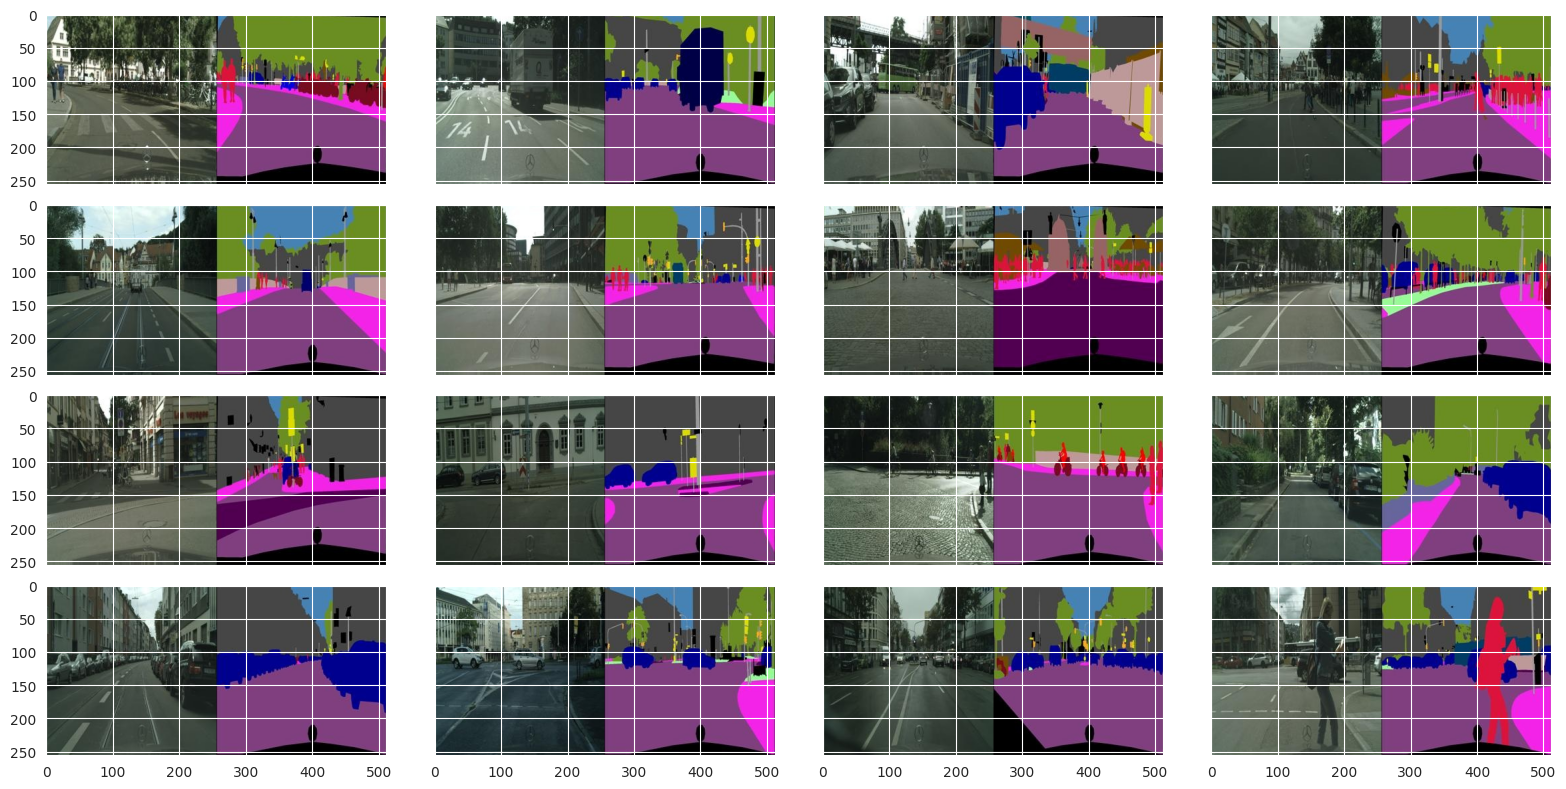

In [12]:
# how many images (total width * height)
width = 4
height = 4
vis_batch_size = width * height

# get vis_batch_size unique, random indices
indexes = np.arange(len(training_images_paths))
indexes = np.random.permutation(indexes)[:vis_batch_size]


# create the plot
fig, axs = plt.subplots(height, width, sharex=True, sharey=True, figsize=(16, 8))
for i in range(vis_batch_size):
    # read the image
    img = torchvision.io.read_image(training_images_paths[indexes[i]])

    # pytorch reads it as (c, h, w), reshape it to (h, w, c) which is the shape matplotlib wants
    img = img.permute(1, 2, 0)

    # calculate the indexes for plots and set the image data
    y, x = i // width, i % width
    axs[y, x].imshow(img.numpy())

plt.tight_layout()

#### 2.2.1.2 Pixel intensity histogram

These visualizations can provide insights into the distribution of pixel intensities, the spatial relationships between images and masks, and the overall characteristics the dataset.

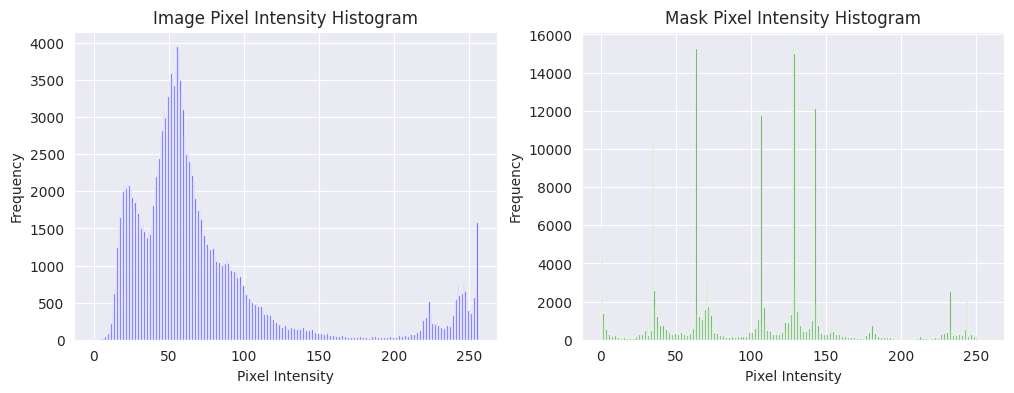

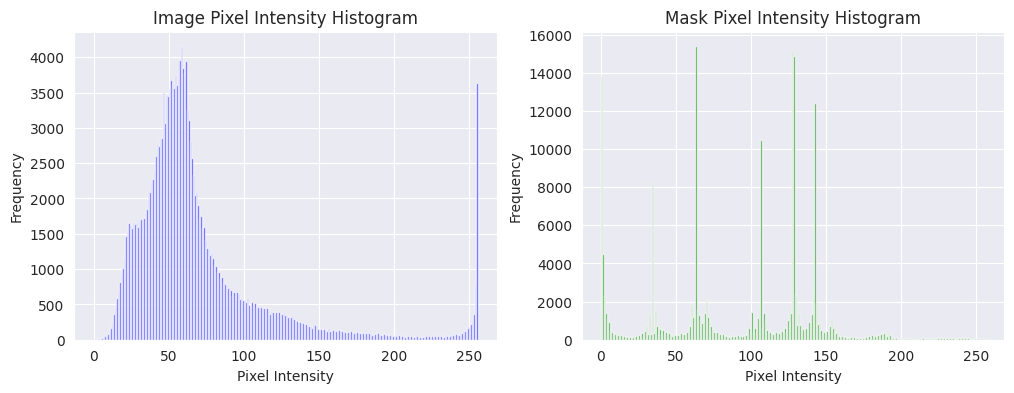

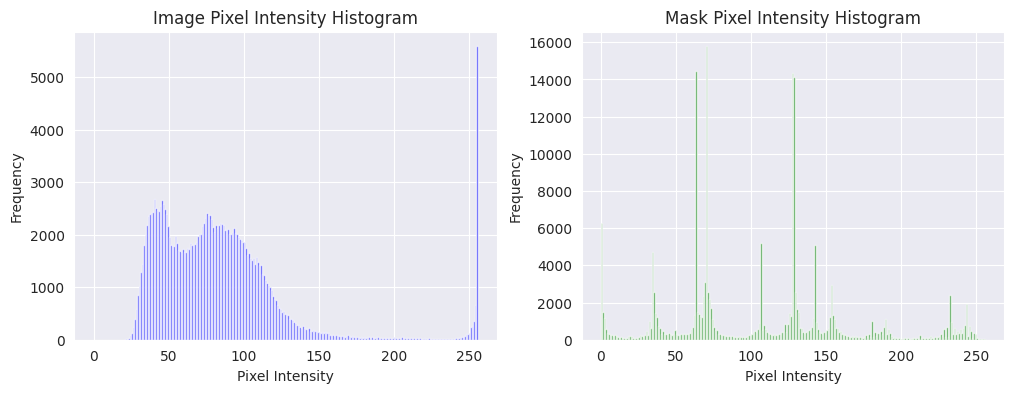

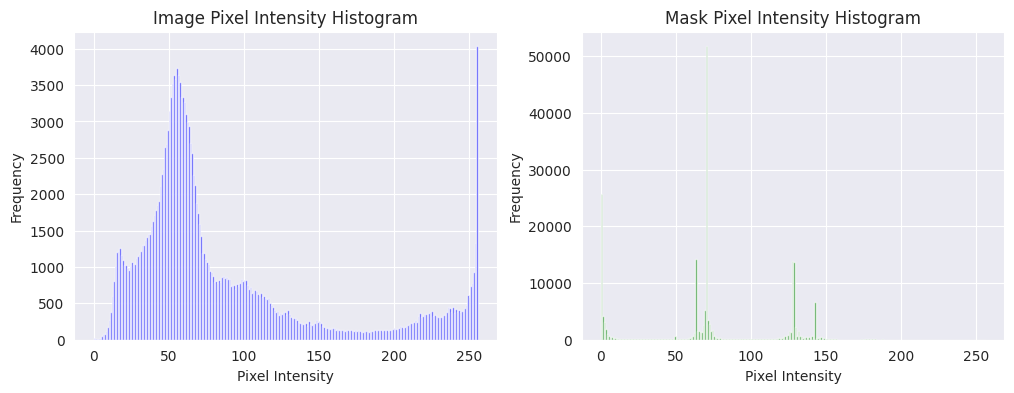

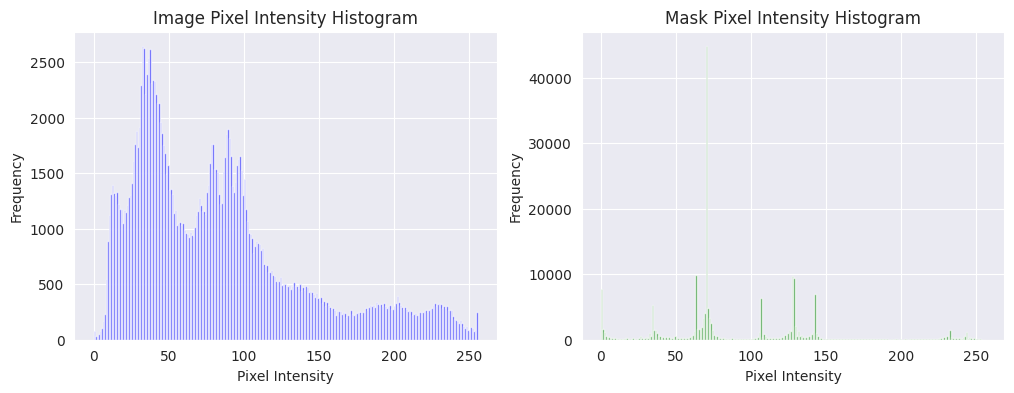

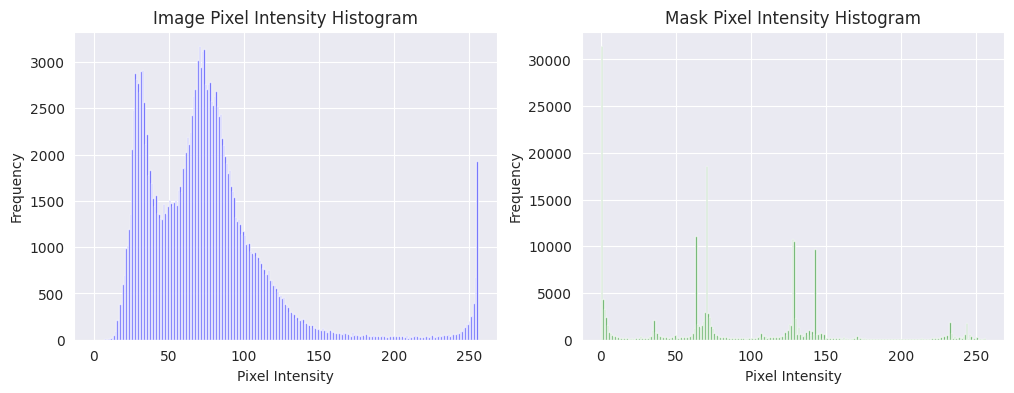

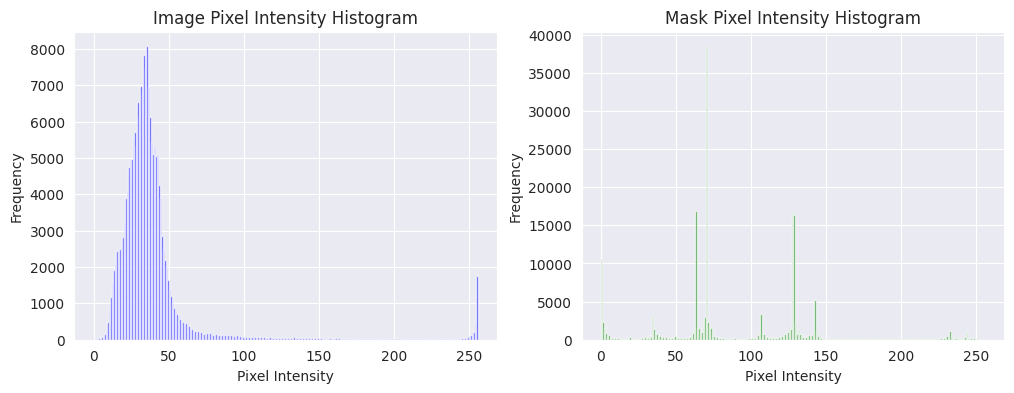

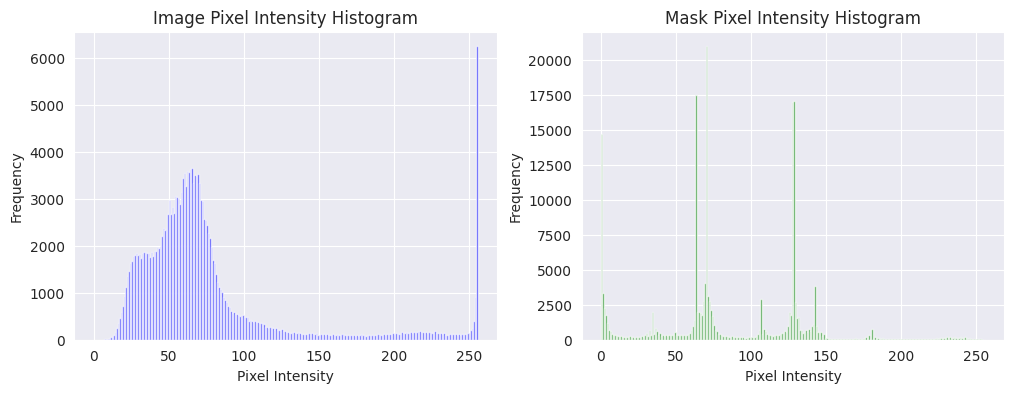

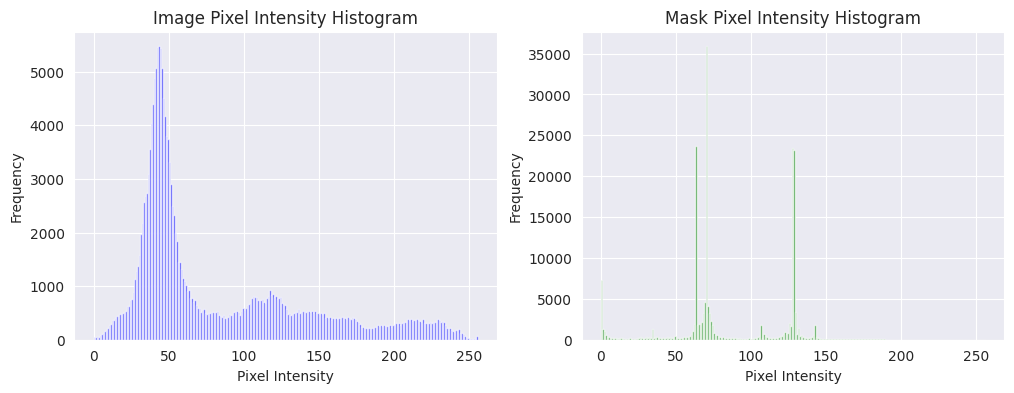

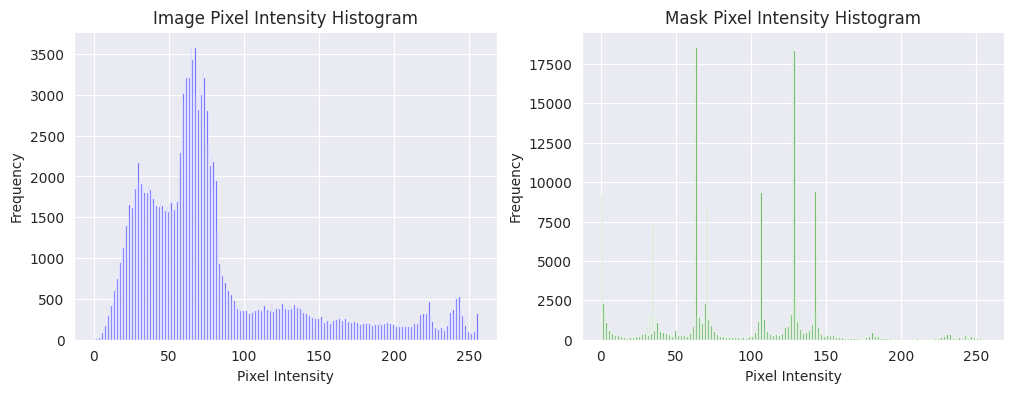

In [35]:
# Plot histogram of pixel intensities for an image

# Take only the first 10 file paths
first_10_image_files = training_images_paths[:10]

# Process each image
for image_file in first_10_image_files:
    image_path = os.path.join(train_cs_datapath, image_file)
    combined_image = io.imread(image_path)

    # Split the image into input and mask regions
    input_region = combined_image[:,:256,:]
    mask_region = combined_image[:, 256:,:]

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.hist(input_region.flatten(), bins=256, range=[0, 256], color='blue', alpha=0.7)
    plt.title('Image Pixel Intensity Histogram')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')

    plt.subplot(1, 2, 2)
    plt.hist(mask_region.flatten(), bins=256, range=[0, 256], color='green', alpha=0.7)
    plt.title('Mask Pixel Intensity Histogram')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')

    plt.show()


## 2.3 Preprocessing

### 2.3.1 Feature normalization

#### 2.3.1.1 Processing the images & 2.3.1.3 Standard Scaling

In [13]:
#--------------------------------------------------------------------------------
#  Load images in, crop for the image and mask, resize, and then encode mask
#--------------------------------------------------------------------------------
def image_mask_split(filename, image_size):
    image_mask = Image.open(filename)
    image, mask = image_mask.crop([0, 0, 256, 256]), image_mask.crop([256, 0, 512, 256])

    image = image.resize(image_size)
    mask = mask.resize(image_size)

    image = np.array(image, dtype='float32') / 255.0 # crop image section and reformat as normalized np array
    mask = np.array(mask) # crop mask section and reformat as np array

    # Sharpen the image
    #image = cv.filter2D(image, -1, np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]]))
    #mask = cv.filter2D(mask, -1, np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]]))

    return image, mask

#--------------------------------------------------------------------------------
# Remap mask half of image into sparse matrix using closest color value
#--------------------------------------------------------------------------------

def find_closest_labels_vectorized(mask, mapping): # 'mapping' is a RGB color tuple to categorical number dictionary

    closest_distance = np.full([mask.shape[0], mask.shape[1]], 10000)
    closest_category = np.full([mask.shape[0], mask.shape[1]], None)

    for id, color in mapping.items(): # iterate over every color mapping
        dist = np.sqrt(np.linalg.norm(mask - color.reshape([1,1,-1]), axis=-1))
        is_closer = closest_distance > dist
        closest_distance = np.where(is_closer, dist, closest_distance)
        closest_category = np.where(is_closer, id, closest_category)

    return closest_category

The use of sharpening filter on each image did not enhance the training and validation accuracy that much so it was not used as it increased the processing time and did not enhance the accuracy

#### 2.3.1.2 Load dataset

There aren't that many images for training/validation and the size of them is pretty small, therefore to speed up the computation, we can
just load them into RAM. This will be achieved by preprocessing as above all paths, and appending the input images and proper masks to python arrays <br><br>
The images themselves are scaled to [0, 1] and converted to PyTorch Tensors (with the (c, h, w) convention )

In [14]:
# Store the images, the masks, and the encoded masks
X_train = []
train_masks = []
Y_train = []
X_val = []
val_masks = []
Y_val = []

for train_file in tqdm(os.listdir(train_cs_datapath), desc = 'Building Training Dataset: '):
    image, mask = image_mask_split(train_cs_datapath + train_file, IMAGE_SIZE)
    X_train.append(image)
    train_masks.append(mask)
    Y_train.append(find_closest_labels_vectorized(mask, id2color))

for val_file in tqdm(os.listdir(val_cs_datapath), desc = 'Building Validation Dataset: '):
    image, mask = image_mask_split(val_cs_datapath + val_file, IMAGE_SIZE)
    X_val.append(image)
    val_masks.append(mask)
    Y_val.append(find_closest_labels_vectorized(mask, id2color))

X_train = np.array(X_train, dtype='float32')
Y_train = np.array(Y_train, dtype='float32')
X_val = np.array(X_val, dtype='float32')
Y_val = np.array(Y_val, dtype='float32')

Building Validation Dataset: 100%|██████████| 500/500 [00:27<00:00, 18.23it/s]


In [15]:
print(f"size of X_train : {len(X_train)} ; Y_train {len(Y_train)}")
print(f"size of X_val : {len(X_val)} ; Y_val {len(Y_val)}")

size of X_train : 2975 ; Y_train 2975
size of X_val : 500 ; Y_val 500


## 2.4 Neural Network construction

### 2.4.1 Keras model creation

#### 2.4.1.1 U-Net model building

##### 2.4.1.1.1 U-Net model

U-Net is a deep learning architecture designed for semantic segmentation tasks, particularly in the field of medical image analysis. It was introduced by Olaf Ronneberger, Philipp Fischer, and Thomas Brox in 2015. The U-Net architecture is named after its U-shaped structure, which consists of a contracting path, a bottleneck, and an expansive path.

Here's a brief explanation of the key components of the U-Net architecture:

- Contracting Path (Encoder):
The top part of the U, often referred to as the encoder or contracting path, is designed to capture the contextual information and reduce the spatial resolution of the input image.
It consists of a series of convolutional and max-pooling layers that progressively decrease the spatial dimensions while increasing the number of feature channels.
Each convolutional layer is typically followed by batch normalization and a rectified linear unit (ReLU) activation function.

- Bottleneck:
The bottleneck is the central part of the U-Net and acts as a bridge between the contracting and expansive paths.
It consists of a set of convolutional layers without max-pooling, allowing it to maintain a higher resolution feature map.
This part captures the most essential features while preserving spatial information.

- Expansive Path (Decoder):
The bottom part of the U, known as the decoder or expansive path, is responsible for restoring the spatial resolution of the feature map and generating the final segmentation map.
It consists of a series of upsampling layers (transposed convolutions) that increase the spatial dimensions, along with concatenation of feature maps from the contracting path to provide high-resolution context.
Each upsampling layer is followed by convolutional layers, batch normalization, and ReLU activations.

- Skip Connections:
Skip connections connect the feature maps from the contracting path to the corresponding upsampling layers in the expansive path.
These connections help to preserve fine-grained details and provide context from different scales, enabling the model to recover spatial information lost during downsampling.

- Final Convolutional Layer:
The final layer typically consists of a 1x1 convolutional layer with a softmax activation function to produce pixel-wise probability scores for each class in the segmentation task.
The output is a segmentation map that assigns a class label to each pixel in the input image.

- U-Net has proven to be highly effective for semantic segmentation tasks, particularly in scenarios where the segmentation task involves capturing fine details and intricate structures. Its architecture facilitates the learning of both global and local features, making it well-suited for tasks such as medical image segmentation, cell segmentation, and other image-to-image translation tasks.

![unet.jpg](./unet.jpg)


In [16]:
def create_unet():

    inputs = tf.keras.layers.Input(shape = IMAGE_SHAPE)

    #First Downsample
    f1 = tf.keras.layers.Conv2D(64, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(inputs)
    b1 = tf.keras.layers.BatchNormalization()(f1)
    f2 = tf.keras.layers.Conv2D(64, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(b1)    # Used later for residual connection

    m3 = tf.keras.layers.MaxPooling2D(pool_size = (2, 2), strides = 2)(f2)
    d4 = tf.keras.layers.Dropout(0.2)(m3)

    # Second Downsample
    f5 = tf.keras.layers.Conv2D(128, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(d4)
    b5 = tf.keras.layers.BatchNormalization()(f5)
    f6 = tf.keras.layers.Conv2D(128, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(b5)    # Used later for residual connection

    m7 = tf.keras.layers.MaxPooling2D(pool_size = (2, 2), strides = 2)(f6)
    d8 = tf.keras.layers.Dropout(0.2)(m7)

    # Third Downsample
    f9 = tf.keras.layers.Conv2D(256, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(d8)
    b9 = tf.keras.layers.BatchNormalization()(f9)
    f10 = tf.keras.layers.Conv2D(256, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(b9)    # Used later for residual connection

    m11 = tf.keras.layers.MaxPooling2D(pool_size = (2, 2), strides = 2)(f10)
    d12 = tf.keras.layers.Dropout(0.2)(m11)

    #Forth Downsample
    f13 = tf.keras.layers.Conv2D(512, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(d12)
    b13 = tf.keras.layers.BatchNormalization()(f13)
    f14 = tf.keras.layers.Conv2D(512, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(b13)    # Used later for residual connection

    m15 = tf.keras.layers.MaxPooling2D(pool_size = (2, 2), strides = 2)(f14)
    d16 = tf.keras.layers.Dropout(0.2)(m15)

    #Fifth Downsample
    f17 = tf.keras.layers.Conv2D(1024, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(d16)
    b17 = tf.keras.layers.BatchNormalization()(f17)
    f18 = tf.keras.layers.Conv2D(1024, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(b17)


    # First Upsample
    m19 = tf.keras.layers.UpSampling2D(size = (2, 2))(f18)
    d19 = tf.keras.layers.Dropout(0.2)(m19)
    c20 = tf.keras.layers.Concatenate()([d19, f14])
    f21 = tf.keras.layers.Conv2D(512, kernel_size = (3, 3), padding = "same", strides = 1 ,activation = "relu")(c20)
    b21 = tf.keras.layers.BatchNormalization()(f21)
    f22 = tf.keras.layers.Conv2D(512, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(b21)

    # Second Upsample
    m23 = tf.keras.layers.UpSampling2D(size = (2, 2))(f22)
    d23 = tf.keras.layers.Dropout(0.2)(m23)
    c24 = tf.keras.layers.Concatenate()([d23, f10])
    f25 = tf.keras.layers.Conv2D(256, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(c24)
    b25 = tf.keras.layers.BatchNormalization()(f25)
    f26 = tf.keras.layers.Conv2D(256, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(b25)

    # Third Upsample
    m27 = tf.keras.layers.UpSampling2D(size = (2, 2))(f26)
    d27 = tf.keras.layers.Dropout(0.2)(m27)
    c28 = tf.keras.layers.Concatenate()([d27, f6])
    f29 = tf.keras.layers.Conv2D(128, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(c28)
    b29 = tf.keras.layers.BatchNormalization()(f29)
    f30 = tf.keras.layers.Conv2D(128, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(b29)

    #Forth Upsample
    m31 = tf.keras.layers.UpSampling2D(size = (2, 2))(f30)
    d31 = tf.keras.layers.Dropout(0.2)(m31)
    c32 = tf.keras.layers.Concatenate()([d31, f2])
    f33 = tf.keras.layers.Conv2D(64, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(c32)
    b33 = tf.keras.layers.BatchNormalization()(f33)
    f34 = tf.keras.layers.Conv2D(64, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(b33)

    # Output Layer
    outputs = tf.keras.layers.Conv2D(N_CLASSES, kernel_size = (3, 3), padding = "same", strides = 1, activation = "softmax")(f34)

    model = tf.keras.Model(inputs = [inputs], outputs = [outputs])

    return model

##### 2.4.1.1.2 Creating the model

In [17]:
unet_model = create_unet()

##### 2.4.1.1.3 Plotting the network

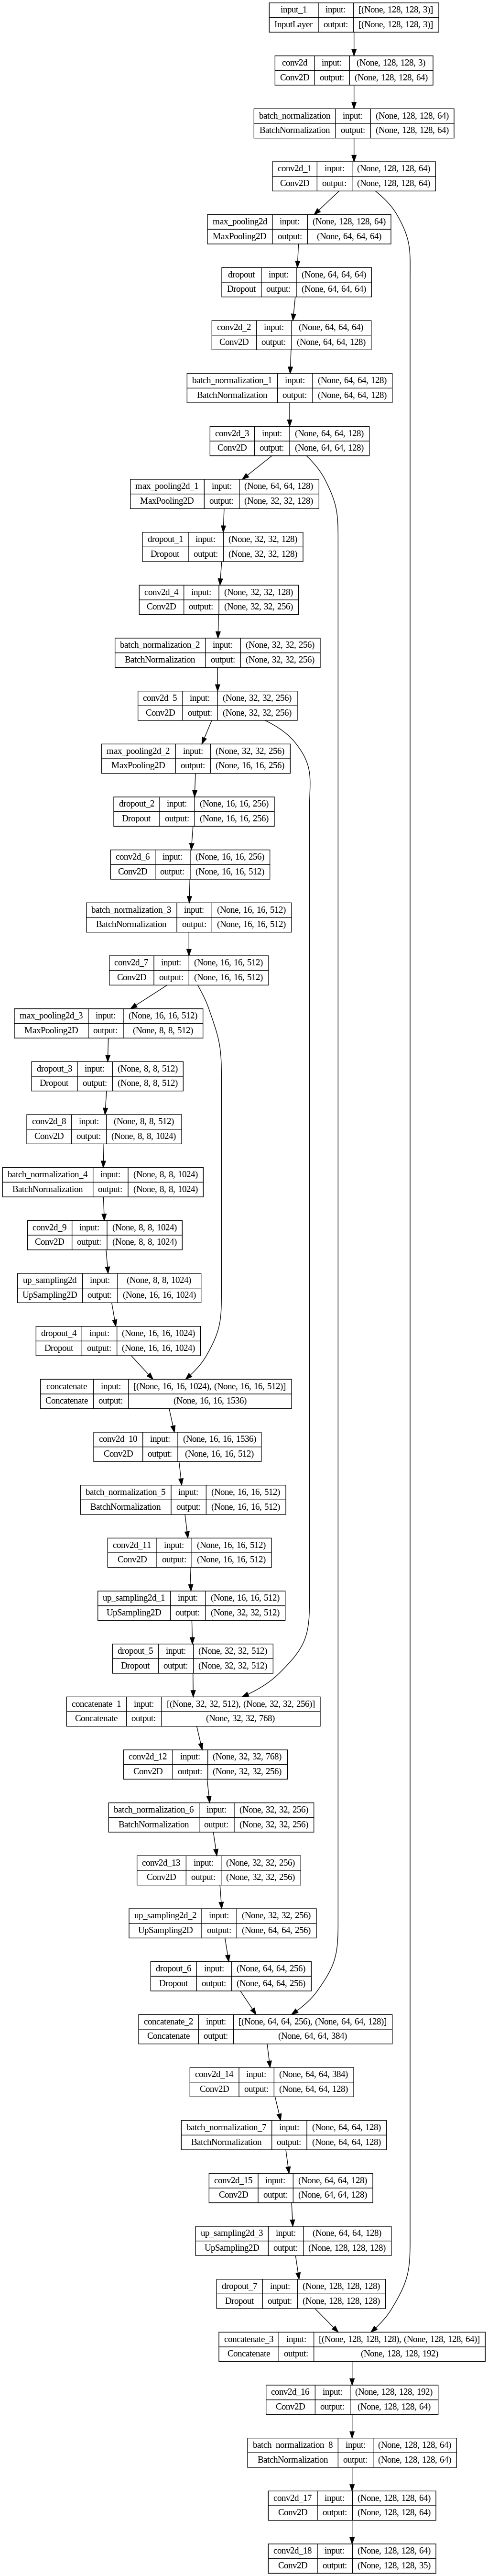

In [18]:
tf.keras.utils.plot_model(unet_model, show_shapes = True)

#### 2.4.1.2 SegNet model building

##### 2.4.1.2.1 SegNet model

SegNet is a deep learning architecture designed for semantic segmentation, a task where the goal is to classify each pixel in an input image into predefined classes. SegNet was introduced by Vijay Badrinarayanan, Alex Kendall, and Roberto Cipolla in 2015. It is specifically designed to perform pixel-wise semantic segmentation while being computationally efficient.

Here's a brief explanation of the key components of the SegNet architecture:

- Encoder:
Similar to U-Net, SegNet has an encoder-decoder architecture. The encoder is responsible for capturing hierarchical features from the input image.
The encoder consists of several convolutional and max-pooling layers. Each convolutional layer is followed by batch normalization and a rectified linear unit (ReLU) activation function.
The max-pooling layers downsample the spatial resolution of the feature maps to capture contextual information.

- Decoder:
The decoder is responsible for reconstructing the high-resolution segmentation map from the encoded features.
SegNet uses an architecture known as "UpProjection," where the upsampling is performed by learning the upsampling filters instead of using traditional interpolation methods.
The decoder includes unpooling layers, which are learned during training to upsample the feature maps.

- Skip Connections:
Similar to U-Net, SegNet employs skip connections to combine low-level and high-level features from different layers.
These skip connections help in preserving fine details and spatial information during the upsampling process.

- Softmax Layer:
The final layer of SegNet is a softmax layer, which produces pixel-wise probability scores for each class in the segmentation task.
The output segmentation map assigns a class label to each pixel in the input image.

- Indices Storage:
SegNet stores the indices of the max-pooling operations during the encoding phase, which are later used in the decoding phase for efficient upsampling. This reduces the number of parameters in the network and makes it more memory-efficient.

- SegNet has been applied to various semantic segmentation tasks, including road scene understanding for autonomous vehicles and medical image segmentation. Its design is tailored to balance accuracy and computational efficiency, making it suitable for real-time applications with limited computational resources.

![segnet.png](./segnet.png)

In [19]:
def create_segnet():

    # Encoder
    inputs = tf.keras.Input(shape=IMAGE_SHAPE)

    # Block 1
    x = tf.keras.layers.Conv2D(64, (3, 3), padding='same' , activation='relu')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid', name='block1_pool')(x)

    # Block 2
    x = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid', name='block2_pool')(x)

    # Decoder
    x = tf.keras.layers.UpSampling2D(size=(2, 2), name='block2_up')(x)
    x = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.UpSampling2D(size=(2, 2), name='block1_up')(x)
    x = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)

    # Output layer
    outputs = tf.keras.layers.Conv2D(N_CLASSES, (1, 1), activation='softmax', padding='valid')(x)

    # Create the model
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name='segnet')

    return model


##### 2.4.1.2.2 Creating the model

In [20]:
SegNet_model = create_segnet()

##### 2.4.1.2.3 Plotting the network

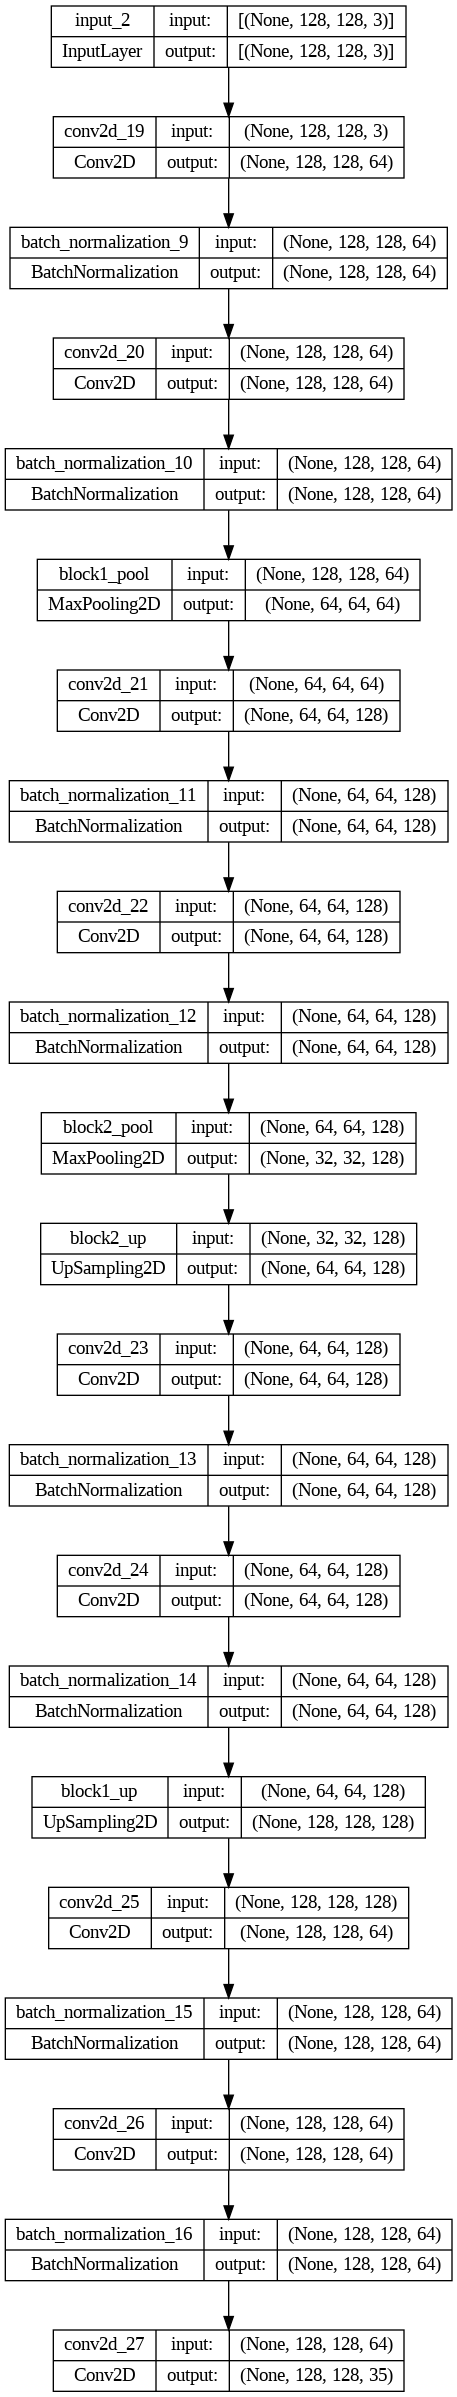

In [21]:
tf.keras.utils.plot_model(SegNet_model, show_shapes = True)

### 2.4.2 Keras compiler

#### 2.4.2.1 U-Net model compile

In [22]:
unet_model.compile(optimizer = 'adam',
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

##### 2.4.2.1.1 U-Net model summary

In [23]:
unet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 128, 128, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 conv2d_1 (Conv2D)           (None, 128, 128, 64)         36928     ['batch_normalization[0][0

#### 2.4.2.2 SegNet model compile

In [24]:
SegNet_model.compile(
            optimizer='adam',
            loss = 'sparse_categorical_crossentropy',
            metrics=['accuracy'])

##### 2.4.2.2.1 SegNet model summary

In [25]:
SegNet_model.summary()

Model: "segnet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_19 (Conv2D)          (None, 128, 128, 64)      1792      
                                                                 
 batch_normalization_9 (Bat  (None, 128, 128, 64)      256       
 chNormalization)                                                
                                                                 
 conv2d_20 (Conv2D)          (None, 128, 128, 64)      36928     
                                                                 
 batch_normalization_10 (Ba  (None, 128, 128, 64)      256       
 tchNormalization)                                               
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0    

### 2.4.3 Model fitting

#### 2.4.3.1 U-Net model fitting

In [26]:
unet_history = unet_model.fit(
              X_train, Y_train,
              epochs= 40,
              batch_size = 16,
              verbose=1,
              validation_data=(X_val, Y_val))

Epoch 1/40
186/186 [==============================] - 120s 460ms/step - loss: 1.0877 - accuracy: 0.7021 - val_loss: 2.1490 - val_accuracy: 0.5034
Epoch 2/40
186/186 [==============================] - 59s 318ms/step - loss: 0.8365 - accuracy: 0.7711 - val_loss: 1.6084 - val_accuracy: 0.5434
Epoch 3/40
186/186 [==============================] - 59s 319ms/step - loss: 0.7453 - accuracy: 0.7969 - val_loss: 1.1008 - val_accuracy: 0.7078
Epoch 4/40
186/186 [==============================] - 59s 318ms/step - loss: 0.6899 - accuracy: 0.8111 - val_loss: 0.7832 - val_accuracy: 0.7995
Epoch 5/40
186/186 [==============================] - 59s 318ms/step - loss: 0.6536 - accuracy: 0.8188 - val_loss: 0.7514 - val_accuracy: 0.7954
Epoch 6/40
186/186 [==============================] - 59s 318ms/step - loss: 0.6226 - accuracy: 0.8267 - val_loss: 0.7259 - val_accuracy: 0.7959
Epoch 7/40
186/186 [==============================] - 59s 319ms/step - loss: 0.6003 - accuracy: 0.8318 - val_loss: 0.7030 - val_a

#### 2.4.3.2 SegNet model fitting

In [27]:
SegNet_history = SegNet_model.fit(
              X_train, Y_train,
              batch_size = 16,
              epochs= 40,
              verbose=1,
              validation_data=(X_val, Y_val))

Epoch 1/40
186/186 [==============================] - 36s 148ms/step - loss: 1.2579 - accuracy: 0.6865 - val_loss: 8.4164 - val_accuracy: 0.3277
Epoch 2/40
186/186 [==============================] - 24s 128ms/step - loss: 0.9415 - accuracy: 0.7498 - val_loss: 5.8711 - val_accuracy: 0.3328
Epoch 3/40
186/186 [==============================] - 24s 129ms/step - loss: 0.8542 - accuracy: 0.7700 - val_loss: 1.7779 - val_accuracy: 0.5867
Epoch 4/40
186/186 [==============================] - 24s 129ms/step - loss: 0.7952 - accuracy: 0.7840 - val_loss: 0.9227 - val_accuracy: 0.7545
Epoch 5/40
186/186 [==============================] - 24s 129ms/step - loss: 0.7647 - accuracy: 0.7906 - val_loss: 0.8952 - val_accuracy: 0.7512
Epoch 6/40
186/186 [==============================] - 24s 129ms/step - loss: 0.7361 - accuracy: 0.7976 - val_loss: 1.0721 - val_accuracy: 0.7116
Epoch 7/40
186/186 [==============================] - 24s 128ms/step - loss: 0.7121 - accuracy: 0.8029 - val_loss: 0.7969 - val_ac

### 2.4.4 Model predicting

#### 2.4.4.1 U-Net model predicting

1/1 [==============================] - 0s 19ms/step


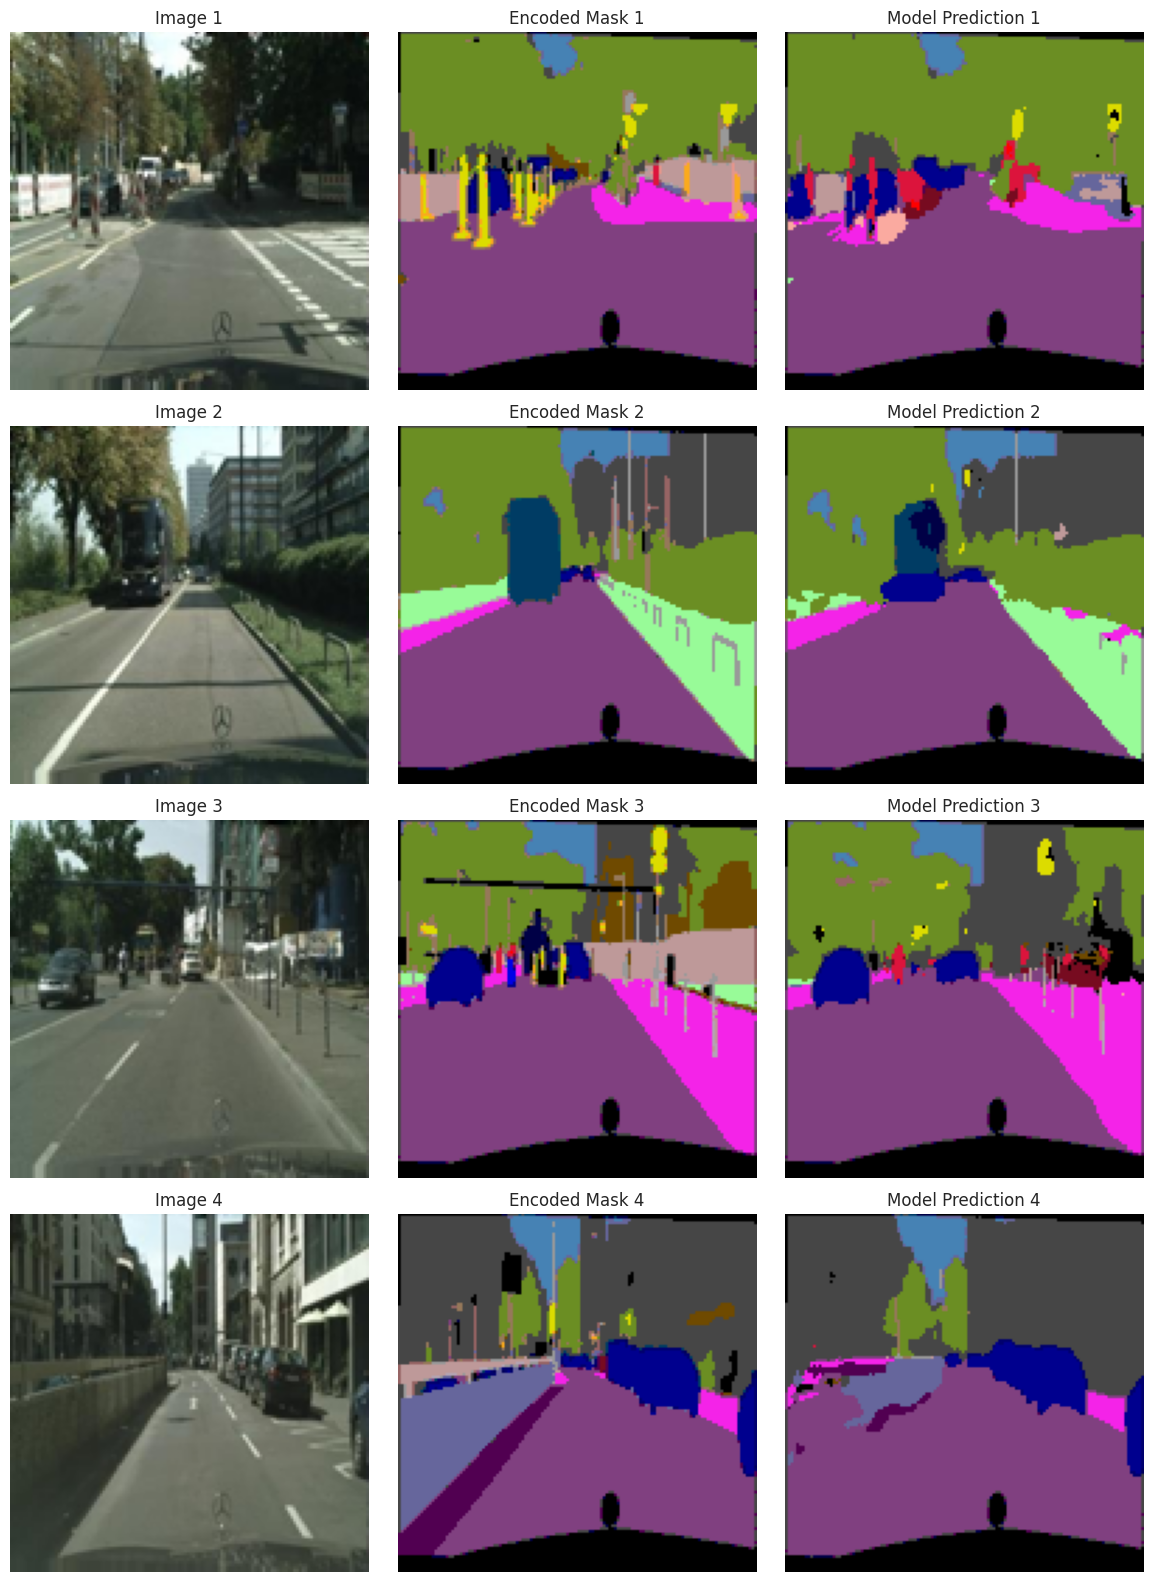

In [28]:
plt.figure(figsize=[15, 20])

id2color = { label.id : np.asarray(label.color) for label in labels }

for i in range(4):
    img = X_val[i]
    enc = Y_val[i]

    pred = unet_model.predict(img.reshape([1] + IMAGE_SHAPE))
    pred = np.squeeze(np.argmax(pred, axis=-1))

    tmp1 = np.zeros([enc.shape[0], enc.shape[1], 3])
    tmp2 = np.zeros([enc.shape[0], enc.shape[1], 3])


    for row in range(enc.shape[0]):
        for col in range(enc.shape[1]):
            tmp1[row, col, :] = id2color[enc[row, col]]
            tmp1 = tmp1.astype('uint8')

            tmp2[row, col, :] = id2color[pred[row, col]]
            tmp2 = tmp2.astype('uint8')

    plt.subplot(4, 3, i*3 + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.gca().set_title('Image {}'.format(str(i+1)))

    plt.subplot(4, 3, i*3 + 2)
    plt.imshow(tmp1)
    plt.axis('off')
    plt.gca().set_title('Encoded Mask {}'.format(str(i+1)))

    plt.subplot(4, 3, i*3 + 3)
    plt.imshow(tmp2)
    plt.axis('off')
    plt.gca().set_title('Model Prediction {}'.format(str(i+1)))

plt.subplots_adjust(wspace=0, hspace=0.1)

#### 2.4.4.2 SegNet model predicting

1/1 [==============================] - 0s 26ms/step


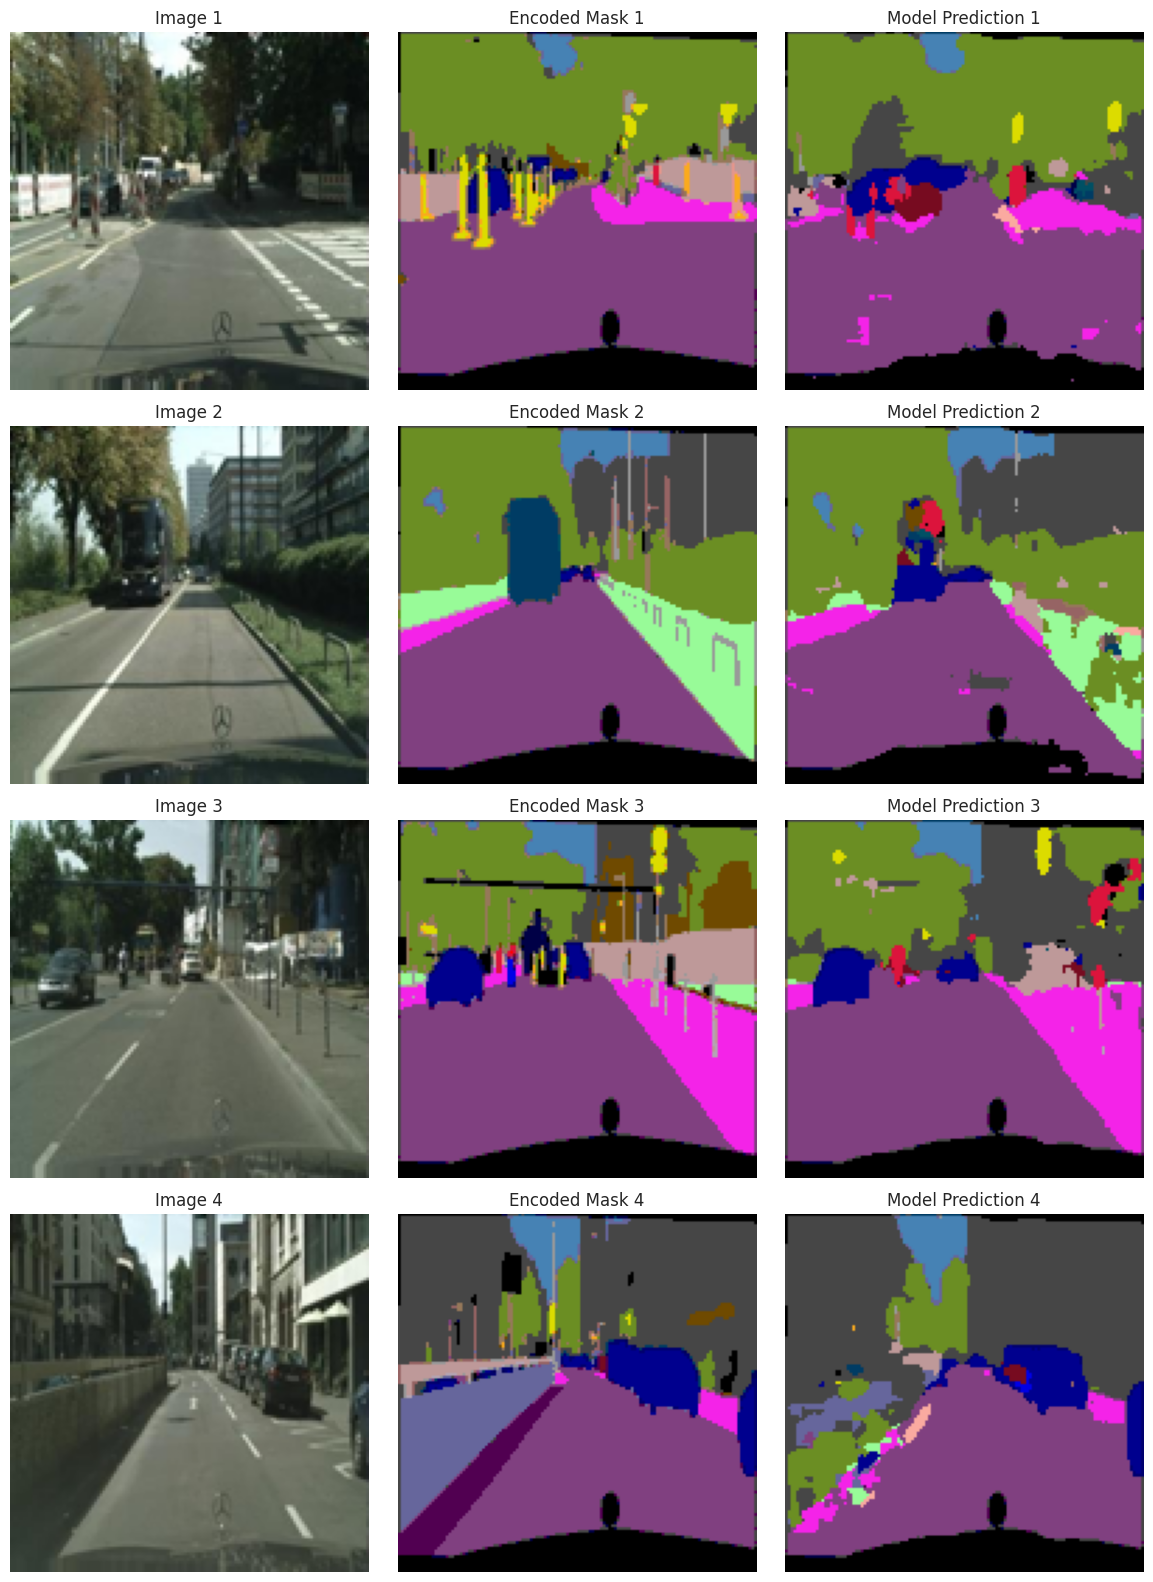

In [29]:
plt.figure(figsize=[15, 20])

for i in range(4):
    img = X_val[i]
    enc = Y_val[i]

    pred = SegNet_model.predict(img.reshape([1] + IMAGE_SHAPE))
    pred = np.squeeze(np.argmax(pred, axis=-1))

    tmp1 = np.zeros([enc.shape[0], enc.shape[1], 3])
    tmp2 = np.zeros([enc.shape[0], enc.shape[1], 3])


    for row in range(enc.shape[0]):
        for col in range(enc.shape[1]):
            tmp1[row, col, :] = id2color[enc[row, col]]
            tmp1 = tmp1.astype('uint8')

            tmp2[row, col, :] = id2color[pred[row, col]]
            tmp2 = tmp2.astype('uint8')

    plt.subplot(4, 3, i*3 + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.gca().set_title('Image {}'.format(str(i+1)))

    plt.subplot(4, 3, i*3 + 2)
    plt.imshow(tmp1)
    plt.axis('off')
    plt.gca().set_title('Encoded Mask {}'.format(str(i+1)))

    plt.subplot(4, 3, i*3 + 3)
    plt.imshow(tmp2)
    plt.axis('off')
    plt.gca().set_title('Model Prediction {}'.format(str(i+1)))

plt.subplots_adjust(wspace=0, hspace=0.1)

## 2.5 Evaluation metrics

### 2.5.1 Training accuracy & 2.5.3 Test accuracy

#### 2.5.1.1 U-Net model

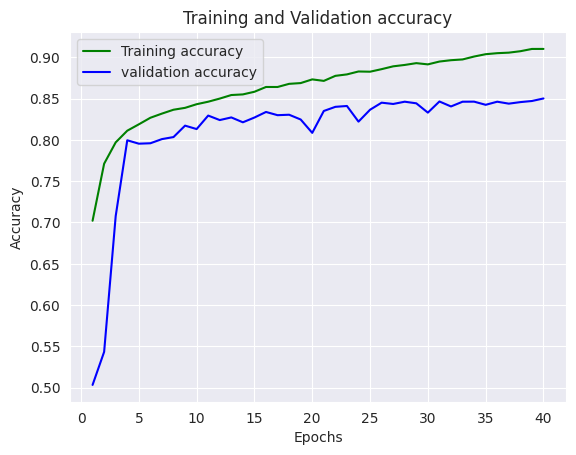

In [30]:
train_accuracy = unet_history.history['accuracy']
val_accuracy = unet_history.history['val_accuracy']

epochs = range(1,unet_history.epoch[-1]+2)
plt.plot(epochs, train_accuracy, 'g', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#### 2.5.1.2 SegNet model

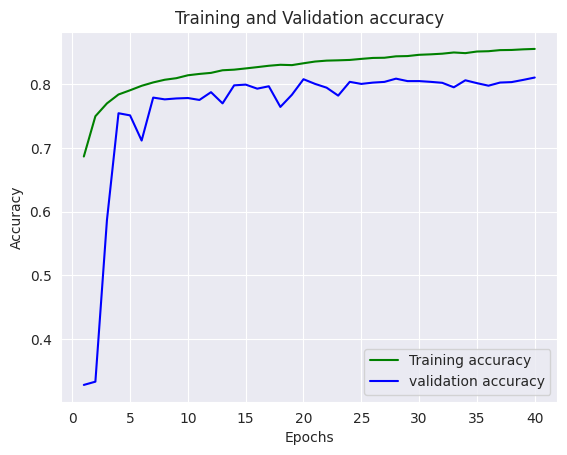

In [31]:
train_accuracy = SegNet_history.history['accuracy']
val_accuracy = SegNet_history.history['val_accuracy']

epochs = range(1,SegNet_history.epoch[-1]+2)
plt.plot(epochs, train_accuracy, 'g', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### 2.5.2 Training loss & 2.5.4 Test loss

#### 2.5.2.1 U-Net model

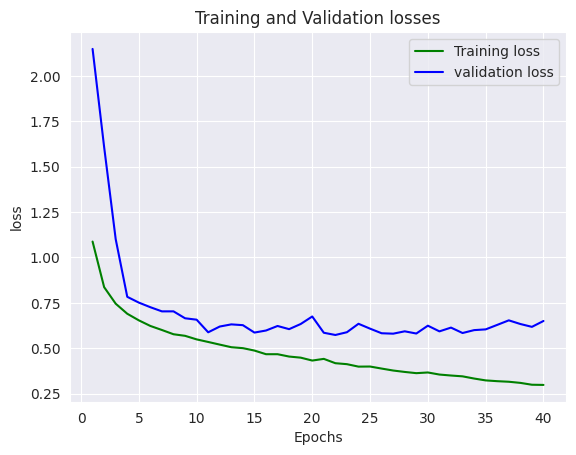

In [32]:
train_loss = unet_history.history['loss']
val_loss = unet_history.history['val_loss']

plt.plot(epochs, train_loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('Training and Validation losses')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

#### 2.5.2.2 SegNet model

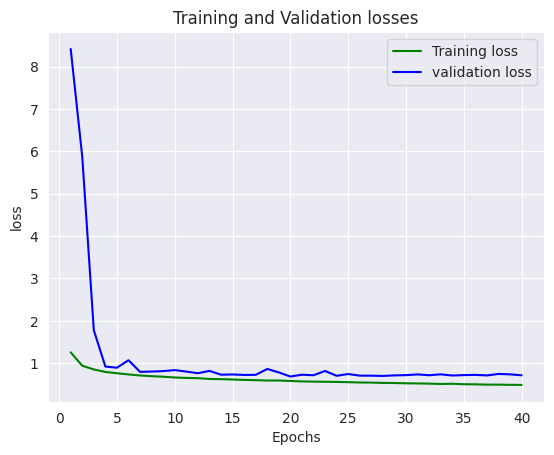

In [33]:
train_loss = SegNet_history.history['loss']
val_loss = SegNet_history.history['val_loss']

plt.plot(epochs, train_loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('Training and Validation losses')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.show()